# Análise e tratamento da base de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [2]:
df = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')

### Transformação dos dados

A coluna "date_time", como o nome indica, contém todos os dados sobre as datas e horários dos eventos. Mas para que a máquina considere esses dados de forma independente, teremos de separar esses dados em diferentes colunas.

In [3]:
df['day'] = (pd.to_datetime(df['date_time']).dt.day).astype(int)
df['month'] = (pd.to_datetime(df['date_time']).dt.month).astype(int)
df['year'] = (pd.to_datetime(df['date_time']).dt.year).astype(int)
df['hour'] = (pd.to_datetime(df['date_time']).dt.hour).astype(int)
del df['date_time']

### Outliers e dados inconsistentes

Checaremos a presença de outliers(representados pelos pontos vermelhos) por meio do uso de diagramas de caixa e das medidas de posição e dispersão.

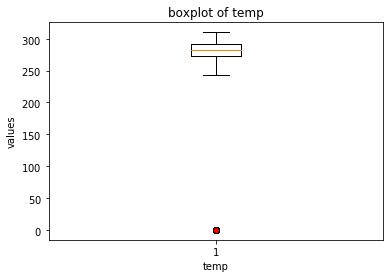

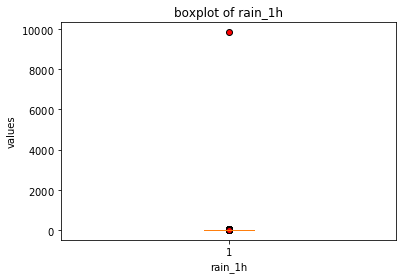

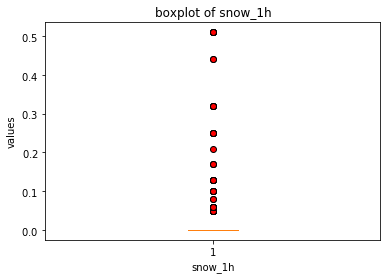

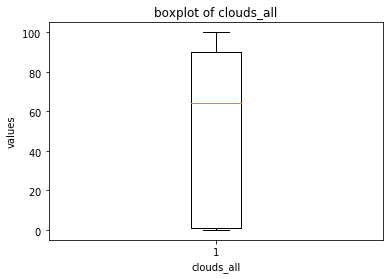

In [4]:
boxplot_columns = ['temp','rain_1h','snow_1h','clouds_all']
for i,column in zip(range(len(boxplot_columns)),boxplot_columns):
    plt.figure(i)
    outlier = dict(markerfacecolor='r', marker='o')
    plt.boxplot(df[column],flierprops=outlier)
    plt.title(f'boxplot of {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('values')
    plt.ticklabel_format(style='sci', axis='y', useMathText = True)

Como se pode observar nos gráficos, as colunas temp, rain_1h e snow_1h apresentam outliers. Agora basta descobrirmos se eles representam dados reais.

In [5]:
measures = df.describe(include = 'float')
measures

,temp,rain_1h,snow_1h
count,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222
std,13.338232,44.789133,0.008168
min,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000
50%,282.450000,0.000000,0.000000
75%,291.806000,0.000000,0.000000
max,310.070000,9831.300000,0.510000


#### Temperatura

Começando pela temperatura, obviamente o outlier se trata de um dado falso, uma vez que a temperatura provavelmente está registrada em Kelvin, e o zero absoluto é apenas teórico.

In [6]:
df['temp'].loc[df['temp'] == 0] = np.nan

/home/j-wallace/anaconda3/envs/jw/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### Chuva

Quanto à chuva, há um ponto certamente inconsistente, já que os dados se encontram em sua maioria concentrados entre 0 e 50.

In [7]:
df['rain_1h'].loc[df['rain_1h'] > 100] = np.nan

#### Neve

Aparentemente, os outliers presentes se tratam de dados reais, já que a diferença entre os dados não é alarmante.

Agora, faremos a limpeza dos dados faltosos, inconsistentes e das duplicatas

In [8]:
df = df.dropna(how ='any')
df = df.drop_duplicates()

Visualizando os dados após os tratamentos:

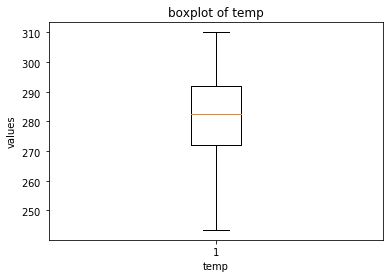

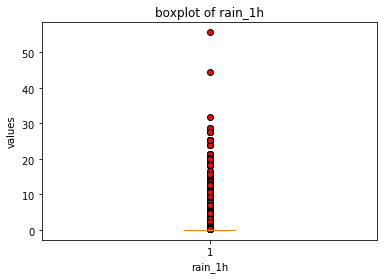

In [9]:
boxplot_columns = ['temp','rain_1h']
for i,column in zip(range(len(boxplot_columns)),boxplot_columns):
    plt.figure(i)
    outlier = dict(markerfacecolor='r', marker='o')
    plt.boxplot(df[column],flierprops=outlier)
    plt.title(f'boxplot of {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('values')
    plt.ticklabel_format(style='sci', axis='y', useMathText = True)

Parece consistente para mim!

### Correlação

A fim de reduzir a dimensionalidade do problema, vamos observar se há a presença de dados correlacionados

In [10]:
corr_matrix = df.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,year,hour
temp,1.000000,0.089943,-0.020861,-0.112881,0.132115,0.022702,0.228473,0.137942,0.113423
rain_1h,0.089943,1.000000,0.001523,0.081490,-0.022372,0.008032,0.028399,-0.032622,-0.011370
snow_1h,-0.020861,0.001523,1.000000,0.027932,0.000732,0.015800,0.020418,-0.003519,0.009849
clouds_all,-0.112881,0.081490,0.027932,1.000000,0.066889,0.048390,-0.009502,-0.073086,0.054287
traffic_volume,0.132115,-0.022372,0.000732,0.066889,1.000000,-0.007923,-0.002766,0.004530,0.352177
day,0.022702,0.008032,0.015800,0.048390,-0.007923,1.000000,0.008667,0.012057,-0.009548
month,0.228473,0.028399,0.020418,-0.009502,-0.002766,0.008667,1.000000,-0.159126,0.001568
year,0.137942,-0.032622,-0.003519,-0.073086,0.004530,0.012057,-0.159126,1.000000,-0.007717
hour,0.113423,-0.011370,0.009849,0.054287,0.352177,-0.009548,0.001568,-0.007717,1.000000


Como se pode observar, não há colunas com alta correlação, então deixaremos os dados como estão.

### Codificação dos dados qualitativos

Para a coluna de feriados, visando reduzir a complexidade dos dados, transformaremos em 0 caso não seja feriado, e em 1 caso contrário.

In [11]:
df['holiday'].loc[df['holiday'] == 'None'] = 0
df['holiday'].loc[df['holiday'] != 0] = 1

/home/j-wallace/anaconda3/envs/jw/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Para o restante dos dados, faremos o encoding por meio do One Hot Encoding.

In [12]:
ohe = skp.OneHotEncoder(sparse=False)

Para tal, usaremos a função abaixo. Tal função irá receber uma coluna como parâmetro uma coluna de nosso Data Frame(df), e a transformará em diferentes colunas, cada uma representando um elemento da coluna anterior.

In [13]:
def encode_column(column_name):
    global df
    encoded = ohe.fit_transform(df[column_name].values.reshape(-1, 1))
    encoded = pd.DataFrame(encoded,index= df.index).drop(columns = {len(encoded[0])-1}) 
    col_names = []
    for i in range(len(encoded.columns)):
        col_names.append(column_name + '_' + str(i))
    encoded.columns = col_names
    df = df.join(encoded)
    del df[column_name]

Agora, só resta aplicar a função em todas as colunas qualitativas

In [14]:
encode_column('weather_main')
encode_column('weather_description')
encode_column('year')
encode_column('month')
encode_column('day')
encode_column('hour')

### Separação dos conjuntos de treino e teste

Com a base de dados tratada, podemos separar o atributo alvo e os outros atributos

In [15]:
y = df['traffic_volume'].values

del df['traffic_volume']

X = df.values

Para a máquina não supervalorizar os valores mais altos, é interessante fazermos a normalização dos atributos quantitativos

In [16]:
sc = skp.StandardScaler()
X[:, 1:5] = sc.fit_transform(X[:, 1:5])

X = X.astype(float)

E dividindo o conjunto treino e teste:

In [17]:
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X,y,test_size = 0.3)  #primeiro split 70/30
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(X,y,test_size = 0.3)  #segundo split 70/30

Agora, temos tudos em mãos para treinar nossos modelos >:)

# Approach 1: Neural Networks

In [18]:
from tensorflow import keras

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Antes de criar nosso modelo, vale ressaltar que o Keras não dispõe uma função R2 Score nativamente, portanto precisaremos implementar a seguinte função:

In [19]:
def keras_r2_score(y_true, y_pred):
    SS_res =  keras.backend.sum(keras.backend.square( y_true-y_pred ))
    SS_tot = keras.backend.sum(keras.backend.square( y_true - keras.backend.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + keras.backend.epsilon()) )

Nosso modelo contará com 4 camadas, sendo três delas ocultas, esse número de camadas e o número de neurônios foi escolhido de maneira arbitrária. E como se trata de um problema de regressão, a ativação de nosso neurônio final será feita linearmente.

In [20]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(len(X[0]), input_dim=len(X[0]), activation='relu'),
        keras.layers.Dense(60, activation = 'relu'),
        keras.layers.Dense(60, activation = 'relu'),
        keras.layers.Dense(1, activation = 'linear')
        ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae', keras_r2_score])

    return model

Na compilação do modelo, usaremos como medida de perda a Mean Squared Error (MSE), a fim de penalizar pela distância entre o valor prevido pelo modelo, e o valor real.

### Cross Validation

In [21]:
# Listas onde será armazenado as métricas
nn_mse = []
nn_mae = []
nn_r2 = []

# Percorredor do KFold
for train_index, test_index in KFold(10).split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Criando o modelo
    model = create_model()
    
    # Treinando o modelo
    model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=1024)
    
    # Fazendo a predição do conjunto teste
    y_pred = model.predict(X_test_cv)

    # Adicionando as métricas às listas
    nn_mse.append(mean_squared_error(y_test_cv, y_pred))
    nn_mae.append(mean_absolute_error(y_test_cv, y_pred))
    nn_r2.append(r2_score(y_test_cv, y_pred))

Train on 43358 samples
Epoch 1/100
43358/43358 [==============================] - 0s 7us/sample - loss: 14583306.0496 - mae: 3261.6819 - keras_r2_score: -2.7050
Epoch 2/100
43358/43358 [==============================] - 0s 3us/sample - loss: 13636645.7493 - mae: 3115.1145 - keras_r2_score: -2.4554
Epoch 3/100
43358/43358 [==============================] - 0s 3us/sample - loss: 7760925.7755 - mae: 2282.7136 - keras_r2_score: -0.9565
Epoch 4/100
43358/43358 [==============================] - 0s 3us/sample - loss: 3182698.4384 - mae: 1539.4915 - keras_r2_score: 0.1939
Epoch 5/100
43358/43358 [==============================] - 0s 3us/sample - loss: 2658792.3822 - mae: 1398.2347 - keras_r2_score: 0.3265
Epoch 6/100
43358/43358 [==============================] - 0s 2us/sample - loss: 2260114.6773 - mae: 1272.9240 - keras_r2_score: 0.4269
Epoch 7/100
43358/43358 [==============================] - 0s 3us/sample - loss: 1895166.6656 - mae: 1149.4005 - keras_r2_score: 0.5202
Epoch 8/100
43358/43

43358/43358 [==============================] - 0s 2us/sample - loss: 832592.8758 - mae: 616.3368 - keras_r2_score: 0.7891
Epoch 62/100
43358/43358 [==============================] - 0s 3us/sample - loss: 831112.1976 - mae: 614.8280 - keras_r2_score: 0.7884
Epoch 63/100
43358/43358 [==============================] - 0s 2us/sample - loss: 830887.9339 - mae: 614.8558 - keras_r2_score: 0.7888
Epoch 64/100
43358/43358 [==============================] - 0s 2us/sample - loss: 829834.6868 - mae: 615.9103 - keras_r2_score: 0.7890
Epoch 65/100
43358/43358 [==============================] - 0s 2us/sample - loss: 828223.3345 - mae: 614.8101 - keras_r2_score: 0.7902
Epoch 66/100
43358/43358 [==============================] - 0s 2us/sample - loss: 827251.8831 - mae: 612.7045 - keras_r2_score: 0.7903
Epoch 67/100
43358/43358 [==============================] - 0s 2us/sample - loss: 826079.2378 - mae: 614.0504 - keras_r2_score: 0.7911
Epoch 68/100
43358/43358 [==============================] - 0s 3us/s

43358/43358 [==============================] - 0s 3us/sample - loss: 868810.7490 - mae: 641.5073 - keras_r2_score: 0.7781
Epoch 22/100
43358/43358 [==============================] - 0s 2us/sample - loss: 866790.3853 - mae: 639.3937 - keras_r2_score: 0.7776
Epoch 23/100
43358/43358 [==============================] - 0s 2us/sample - loss: 864647.3398 - mae: 638.0107 - keras_r2_score: 0.7794
Epoch 24/100
43358/43358 [==============================] - 0s 2us/sample - loss: 862991.5562 - mae: 636.8801 - keras_r2_score: 0.7790
Epoch 25/100
43358/43358 [==============================] - 0s 2us/sample - loss: 861081.7819 - mae: 634.7145 - keras_r2_score: 0.7795
Epoch 26/100
43358/43358 [==============================] - 0s 2us/sample - loss: 859583.9852 - mae: 634.4144 - keras_r2_score: 0.7796
Epoch 27/100
43358/43358 [==============================] - 0s 2us/sample - loss: 858357.4876 - mae: 634.3169 - keras_r2_score: 0.7806
Epoch 28/100
43358/43358 [==============================] - 0s 2us/s

43358/43358 [==============================] - 0s 2us/sample - loss: 800738.9288 - mae: 600.6310 - keras_r2_score: 0.7950
Epoch 82/100
43358/43358 [==============================] - 0s 2us/sample - loss: 798472.5245 - mae: 599.5359 - keras_r2_score: 0.7954
Epoch 83/100
43358/43358 [==============================] - 0s 2us/sample - loss: 794641.1462 - mae: 598.8940 - keras_r2_score: 0.7962
Epoch 84/100
43358/43358 [==============================] - 0s 2us/sample - loss: 792299.2481 - mae: 596.9605 - keras_r2_score: 0.7977
Epoch 85/100
43358/43358 [==============================] - 0s 2us/sample - loss: 789055.9068 - mae: 596.0991 - keras_r2_score: 0.7971
Epoch 86/100
43358/43358 [==============================] - 0s 2us/sample - loss: 786300.3843 - mae: 595.6696 - keras_r2_score: 0.7986
Epoch 87/100
43358/43358 [==============================] - 0s 2us/sample - loss: 782435.9192 - mae: 592.7241 - keras_r2_score: 0.7997
Epoch 88/100
43358/43358 [==============================] - 0s 2us/s

43358/43358 [==============================] - 0s 3us/sample - loss: 853992.7379 - mae: 625.7664 - keras_r2_score: 0.7835
Epoch 42/100
43358/43358 [==============================] - 0s 3us/sample - loss: 853116.4650 - mae: 626.0860 - keras_r2_score: 0.7838
Epoch 43/100
43358/43358 [==============================] - 0s 3us/sample - loss: 852481.1290 - mae: 625.0663 - keras_r2_score: 0.7848
Epoch 44/100
43358/43358 [==============================] - 0s 2us/sample - loss: 851705.8884 - mae: 624.1467 - keras_r2_score: 0.7840
Epoch 45/100
43358/43358 [==============================] - 0s 2us/sample - loss: 851090.8883 - mae: 625.1040 - keras_r2_score: 0.7849
Epoch 46/100
43358/43358 [==============================] - 0s 2us/sample - loss: 850855.2050 - mae: 622.5376 - keras_r2_score: 0.7848
Epoch 47/100
43358/43358 [==============================] - 0s 2us/sample - loss: 850023.6585 - mae: 623.7538 - keras_r2_score: 0.7843
Epoch 48/100
43358/43358 [==============================] - 0s 2us/s

43358/43358 [==============================] - 0s 7us/sample - loss: 14491620.1069 - mae: 3248.0339 - keras_r2_score: -2.6834
Epoch 2/100
43358/43358 [==============================] - 0s 2us/sample - loss: 13469273.2589 - mae: 3087.6304 - keras_r2_score: -2.4130
Epoch 3/100
43358/43358 [==============================] - 0s 2us/sample - loss: 7294731.7872 - mae: 2214.5771 - keras_r2_score: -0.8370
Epoch 4/100
43358/43358 [==============================] - 0s 2us/sample - loss: 3128874.0237 - mae: 1533.8618 - keras_r2_score: 0.2070
Epoch 5/100
43358/43358 [==============================] - 0s 2us/sample - loss: 2604012.9709 - mae: 1385.1862 - keras_r2_score: 0.3396
Epoch 6/100
43358/43358 [==============================] - 0s 2us/sample - loss: 2192712.1064 - mae: 1252.5123 - keras_r2_score: 0.4442
Epoch 7/100
43358/43358 [==============================] - 0s 2us/sample - loss: 1816006.1034 - mae: 1122.6246 - keras_r2_score: 0.5393
Epoch 8/100
43358/43358 [==============================

43358/43358 [==============================] - 0s 2us/sample - loss: 822828.2266 - mae: 612.9130 - keras_r2_score: 0.7918
Epoch 62/100
43358/43358 [==============================] - 0s 2us/sample - loss: 821077.0645 - mae: 610.4222 - keras_r2_score: 0.7914
Epoch 63/100
43358/43358 [==============================] - 0s 2us/sample - loss: 818940.5799 - mae: 611.0386 - keras_r2_score: 0.7911
Epoch 64/100
43358/43358 [==============================] - 0s 2us/sample - loss: 816641.2267 - mae: 609.4549 - keras_r2_score: 0.7924
Epoch 65/100
43358/43358 [==============================] - 0s 2us/sample - loss: 814506.4797 - mae: 609.0827 - keras_r2_score: 0.7927
Epoch 66/100
43358/43358 [==============================] - 0s 2us/sample - loss: 812653.0669 - mae: 607.2600 - keras_r2_score: 0.7934
Epoch 67/100
43358/43358 [==============================] - 0s 3us/sample - loss: 810186.1147 - mae: 607.0886 - keras_r2_score: 0.7941
Epoch 68/100
43358/43358 [==============================] - 0s 2us/s

43358/43358 [==============================] - 0s 2us/sample - loss: 870192.5391 - mae: 641.7138 - keras_r2_score: 0.7784
Epoch 22/100
43358/43358 [==============================] - 0s 2us/sample - loss: 867467.1882 - mae: 640.6213 - keras_r2_score: 0.7792
Epoch 23/100
43358/43358 [==============================] - 0s 2us/sample - loss: 865692.0881 - mae: 638.3318 - keras_r2_score: 0.7797
Epoch 24/100
43358/43358 [==============================] - 0s 2us/sample - loss: 863671.9445 - mae: 636.2549 - keras_r2_score: 0.7785
Epoch 25/100
43358/43358 [==============================] - 0s 2us/sample - loss: 862678.5739 - mae: 636.5782 - keras_r2_score: 0.7802
Epoch 26/100
43358/43358 [==============================] - 0s 2us/sample - loss: 860069.0990 - mae: 635.0295 - keras_r2_score: 0.7810
Epoch 27/100
43358/43358 [==============================] - 0s 3us/sample - loss: 858722.5669 - mae: 633.3839 - keras_r2_score: 0.7813
Epoch 28/100
43358/43358 [==============================] - 0s 2us/s

43358/43358 [==============================] - 0s 2us/sample - loss: 717621.8110 - mae: 564.6710 - keras_r2_score: 0.8170
Epoch 82/100
43358/43358 [==============================] - 0s 3us/sample - loss: 709790.0045 - mae: 561.4159 - keras_r2_score: 0.8186
Epoch 83/100
43358/43358 [==============================] - 0s 2us/sample - loss: 702054.0134 - mae: 558.7083 - keras_r2_score: 0.8210
Epoch 84/100
43358/43358 [==============================] - 0s 2us/sample - loss: 693793.3668 - mae: 553.7096 - keras_r2_score: 0.8222
Epoch 85/100
43358/43358 [==============================] - 0s 2us/sample - loss: 684973.9378 - mae: 551.9313 - keras_r2_score: 0.8241
Epoch 86/100
43358/43358 [==============================] - 0s 2us/sample - loss: 674199.6410 - mae: 546.5852 - keras_r2_score: 0.8277
Epoch 87/100
43358/43358 [==============================] - 0s 2us/sample - loss: 664400.5099 - mae: 541.7567 - keras_r2_score: 0.8307
Epoch 88/100
43358/43358 [==============================] - 0s 3us/s

43358/43358 [==============================] - 0s 3us/sample - loss: 850063.0029 - mae: 626.0092 - keras_r2_score: 0.7866
Epoch 42/100
43358/43358 [==============================] - 0s 3us/sample - loss: 848919.5555 - mae: 625.0625 - keras_r2_score: 0.7871
Epoch 43/100
43358/43358 [==============================] - 0s 3us/sample - loss: 848679.1953 - mae: 623.7582 - keras_r2_score: 0.7871
Epoch 44/100
43358/43358 [==============================] - 0s 2us/sample - loss: 847712.4806 - mae: 623.9253 - keras_r2_score: 0.7870
Epoch 45/100
43358/43358 [==============================] - 0s 2us/sample - loss: 847321.0278 - mae: 623.5422 - keras_r2_score: 0.7871
Epoch 46/100
43358/43358 [==============================] - 0s 2us/sample - loss: 846393.7855 - mae: 623.1149 - keras_r2_score: 0.7872
Epoch 47/100
43358/43358 [==============================] - 0s 2us/sample - loss: 845360.4820 - mae: 622.3402 - keras_r2_score: 0.7875
Epoch 48/100
43358/43358 [==============================] - 0s 2us/s

43359/43359 [==============================] - 0s 7us/sample - loss: 14553897.6086 - mae: 3256.1431 - keras_r2_score: -2.6843
Epoch 2/100
43359/43359 [==============================] - 0s 2us/sample - loss: 13760354.9684 - mae: 3133.0725 - keras_r2_score: -2.4811
Epoch 3/100
43359/43359 [==============================] - 0s 2us/sample - loss: 8664394.0411 - mae: 2412.7773 - keras_r2_score: -1.1874
Epoch 4/100
43359/43359 [==============================] - 0s 2us/sample - loss: 3393152.4658 - mae: 1588.0338 - keras_r2_score: 0.1416
Epoch 5/100
43359/43359 [==============================] - 0s 2us/sample - loss: 2780968.7635 - mae: 1435.4170 - keras_r2_score: 0.2955
Epoch 6/100
43359/43359 [==============================] - 0s 2us/sample - loss: 2405079.6338 - mae: 1320.4258 - keras_r2_score: 0.3916
Epoch 7/100
43359/43359 [==============================] - 0s 2us/sample - loss: 2059788.6192 - mae: 1207.3210 - keras_r2_score: 0.4789
Epoch 8/100
43359/43359 [==============================

43359/43359 [==============================] - 0s 3us/sample - loss: 829614.7722 - mae: 613.7189 - keras_r2_score: 0.7897
Epoch 62/100
43359/43359 [==============================] - 0s 3us/sample - loss: 827891.6070 - mae: 612.7296 - keras_r2_score: 0.7898
Epoch 63/100
43359/43359 [==============================] - 0s 3us/sample - loss: 826085.1408 - mae: 611.5416 - keras_r2_score: 0.7909
Epoch 64/100
43359/43359 [==============================] - 0s 3us/sample - loss: 824895.4149 - mae: 611.9266 - keras_r2_score: 0.7919
Epoch 65/100
43359/43359 [==============================] - 0s 2us/sample - loss: 822592.5577 - mae: 609.4972 - keras_r2_score: 0.7914
Epoch 66/100
43359/43359 [==============================] - 0s 3us/sample - loss: 819313.9693 - mae: 609.6258 - keras_r2_score: 0.7920
Epoch 67/100
43359/43359 [==============================] - 0s 2us/sample - loss: 817323.7672 - mae: 607.4734 - keras_r2_score: 0.7935
Epoch 68/100
43359/43359 [==============================] - 0s 2us/s

43359/43359 [==============================] - 0s 2us/sample - loss: 885631.2501 - mae: 649.6787 - keras_r2_score: 0.7754
Epoch 22/100
43359/43359 [==============================] - 0s 3us/sample - loss: 883320.3520 - mae: 647.7549 - keras_r2_score: 0.7758
Epoch 23/100
43359/43359 [==============================] - 0s 3us/sample - loss: 880500.4907 - mae: 645.4832 - keras_r2_score: 0.7767
Epoch 24/100
43359/43359 [==============================] - 0s 3us/sample - loss: 879377.6010 - mae: 643.9456 - keras_r2_score: 0.7772
Epoch 25/100
43359/43359 [==============================] - 0s 3us/sample - loss: 876971.6880 - mae: 643.3613 - keras_r2_score: 0.7774
Epoch 26/100
43359/43359 [==============================] - 0s 3us/sample - loss: 876186.9924 - mae: 641.9923 - keras_r2_score: 0.7781
Epoch 27/100
43359/43359 [==============================] - 0s 2us/sample - loss: 874434.0449 - mae: 641.6047 - keras_r2_score: 0.7778
Epoch 28/100
43359/43359 [==============================] - 0s 2us/s

43359/43359 [==============================] - 0s 3us/sample - loss: 799416.4766 - mae: 601.7133 - keras_r2_score: 0.7972
Epoch 82/100
43359/43359 [==============================] - 0s 3us/sample - loss: 796645.1047 - mae: 600.2622 - keras_r2_score: 0.7978
Epoch 83/100
43359/43359 [==============================] - 0s 2us/sample - loss: 793547.8364 - mae: 597.5824 - keras_r2_score: 0.7984
Epoch 84/100
43359/43359 [==============================] - 0s 3us/sample - loss: 789086.1696 - mae: 596.7150 - keras_r2_score: 0.7992
Epoch 85/100
43359/43359 [==============================] - 0s 3us/sample - loss: 785475.2796 - mae: 595.0162 - keras_r2_score: 0.8004
Epoch 86/100
43359/43359 [==============================] - 0s 2us/sample - loss: 782059.6153 - mae: 593.0054 - keras_r2_score: 0.8018
Epoch 87/100
43359/43359 [==============================] - 0s 3us/sample - loss: 777399.0288 - mae: 591.7765 - keras_r2_score: 0.8029
Epoch 88/100
43359/43359 [==============================] - 0s 3us/s

43359/43359 [==============================] - 0s 2us/sample - loss: 845158.1362 - mae: 623.2918 - keras_r2_score: 0.7866
Epoch 42/100
43359/43359 [==============================] - 0s 3us/sample - loss: 845060.9758 - mae: 621.7888 - keras_r2_score: 0.7863
Epoch 43/100
43359/43359 [==============================] - 0s 2us/sample - loss: 843885.3857 - mae: 621.9003 - keras_r2_score: 0.7865
Epoch 44/100
43359/43359 [==============================] - 0s 3us/sample - loss: 843052.5366 - mae: 620.7411 - keras_r2_score: 0.7869
Epoch 45/100
43359/43359 [==============================] - 0s 3us/sample - loss: 842906.5143 - mae: 621.7375 - keras_r2_score: 0.7871
Epoch 46/100
43359/43359 [==============================] - 0s 3us/sample - loss: 842555.7388 - mae: 620.5975 - keras_r2_score: 0.7866
Epoch 47/100
43359/43359 [==============================] - 0s 3us/sample - loss: 842151.4585 - mae: 620.8292 - keras_r2_score: 0.7873
Epoch 48/100
43359/43359 [==============================] - 0s 3us/s

43359/43359 [==============================] - 0s 7us/sample - loss: 14484458.3167 - mae: 3245.3635 - keras_r2_score: -2.6773
Epoch 2/100
43359/43359 [==============================] - 0s 2us/sample - loss: 13698096.3751 - mae: 3121.4280 - keras_r2_score: -2.4615
Epoch 3/100
43359/43359 [==============================] - 0s 2us/sample - loss: 8276666.4873 - mae: 2359.0637 - keras_r2_score: -1.0874
Epoch 4/100
43359/43359 [==============================] - 0s 3us/sample - loss: 3280054.7810 - mae: 1574.6407 - keras_r2_score: 0.1703
Epoch 5/100
43359/43359 [==============================] - 0s 3us/sample - loss: 2725747.0044 - mae: 1424.1803 - keras_r2_score: 0.3107
Epoch 6/100
43359/43359 [==============================] - 0s 2us/sample - loss: 2337624.2992 - mae: 1301.7484 - keras_r2_score: 0.4087
Epoch 7/100
43359/43359 [==============================] - 0s 2us/sample - loss: 1980276.2627 - mae: 1182.0400 - keras_r2_score: 0.4995
Epoch 8/100
43359/43359 [==============================

43359/43359 [==============================] - 0s 2us/sample - loss: 849290.5492 - mae: 625.3702 - keras_r2_score: 0.7848
Epoch 62/100
43359/43359 [==============================] - 0s 2us/sample - loss: 848520.4599 - mae: 624.4615 - keras_r2_score: 0.7849
Epoch 63/100
43359/43359 [==============================] - 0s 2us/sample - loss: 847105.9661 - mae: 623.8632 - keras_r2_score: 0.7857
Epoch 64/100
43359/43359 [==============================] - 0s 2us/sample - loss: 844989.8626 - mae: 621.8967 - keras_r2_score: 0.7863
Epoch 65/100
43359/43359 [==============================] - 0s 2us/sample - loss: 843234.9840 - mae: 621.9398 - keras_r2_score: 0.7860
Epoch 66/100
43359/43359 [==============================] - 0s 2us/sample - loss: 843219.4043 - mae: 622.5461 - keras_r2_score: 0.7858
Epoch 67/100
43359/43359 [==============================] - 0s 2us/sample - loss: 841376.1668 - mae: 620.6769 - keras_r2_score: 0.7869
Epoch 68/100
43359/43359 [==============================] - 0s 2us/s

### Primeiro Split

In [22]:
model = create_model()

In [23]:
history_1 = model.fit(X_train_s1, y_train_s1, epochs=200, batch_size=512, validation_data = (X_test_s1,y_test_s1))

Train on 33723 samples, validate on 14453 samples
Epoch 1/200
33723/33723 [==============================] - 0s 11us/sample - loss: 14310041.1266 - mae: 3218.8538 - keras_r2_score: -2.6320 - val_loss: 13666275.2203 - val_mae: 3120.5227 - val_keras_r2_score: -2.4862
Epoch 2/200
33723/33723 [==============================] - 0s 5us/sample - loss: 8636100.8703 - mae: 2397.7007 - keras_r2_score: -1.1941 - val_loss: 3383695.9317 - val_mae: 1599.4757 - val_keras_r2_score: 0.1384
Epoch 3/200
33723/33723 [==============================] - 0s 5us/sample - loss: 2970127.5628 - mae: 1486.0793 - keras_r2_score: 0.2470 - val_loss: 2593759.8574 - val_mae: 1377.7793 - val_keras_r2_score: 0.3390
Epoch 4/200
33723/33723 [==============================] - 0s 5us/sample - loss: 2316716.3785 - mae: 1290.5050 - keras_r2_score: 0.4129 - val_loss: 2024051.8651 - val_mae: 1193.0316 - val_keras_r2_score: 0.4841
Epoch 5/200
33723/33723 [==============================] - 0s 5us/sample - loss: 1777353.2903 - mae:

33723/33723 [==============================] - 0s 5us/sample - loss: 847463.0980 - mae: 623.0970 - keras_r2_score: 0.7847 - val_loss: 850195.2841 - val_mae: 629.0863 - val_keras_r2_score: 0.7828
Epoch 41/200
33723/33723 [==============================] - 0s 5us/sample - loss: 845526.9126 - mae: 623.7102 - keras_r2_score: 0.7852 - val_loss: 846020.6059 - val_mae: 620.5370 - val_keras_r2_score: 0.7839
Epoch 42/200
33723/33723 [==============================] - 0s 5us/sample - loss: 845088.8064 - mae: 622.3688 - keras_r2_score: 0.7855 - val_loss: 847942.8301 - val_mae: 627.4514 - val_keras_r2_score: 0.7832
Epoch 43/200
33723/33723 [==============================] - 0s 5us/sample - loss: 844483.7166 - mae: 621.6481 - keras_r2_score: 0.7854 - val_loss: 847395.4954 - val_mae: 625.0397 - val_keras_r2_score: 0.7835
Epoch 44/200
33723/33723 [==============================] - 0s 5us/sample - loss: 841475.9334 - mae: 620.4856 - keras_r2_score: 0.7860 - val_loss: 844833.8268 - val_mae: 619.4993 - 

33723/33723 [==============================] - 0s 5us/sample - loss: 707939.9975 - mae: 559.8995 - keras_r2_score: 0.8201 - val_loss: 751522.6737 - val_mae: 585.5059 - val_keras_r2_score: 0.8079
Epoch 80/200
33723/33723 [==============================] - 0s 5us/sample - loss: 701972.8482 - mae: 559.0289 - keras_r2_score: 0.8218 - val_loss: 743106.0154 - val_mae: 573.4286 - val_keras_r2_score: 0.8100
Epoch 81/200
33723/33723 [==============================] - 0s 5us/sample - loss: 691998.1240 - mae: 552.9415 - keras_r2_score: 0.8243 - val_loss: 738053.7754 - val_mae: 572.7231 - val_keras_r2_score: 0.8112
Epoch 82/200
33723/33723 [==============================] - 0s 5us/sample - loss: 686157.4481 - mae: 550.4477 - keras_r2_score: 0.8259 - val_loss: 733895.3998 - val_mae: 574.3959 - val_keras_r2_score: 0.8124
Epoch 83/200
33723/33723 [==============================] - 0s 5us/sample - loss: 678648.5256 - mae: 547.5730 - keras_r2_score: 0.8276 - val_loss: 725073.2803 - val_mae: 561.9149 - 

33723/33723 [==============================] - 0s 5us/sample - loss: 285256.5013 - mae: 352.0075 - keras_r2_score: 0.9276 - val_loss: 377939.4256 - val_mae: 403.5582 - val_keras_r2_score: 0.9040
Epoch 119/200
33723/33723 [==============================] - 0s 5us/sample - loss: 278376.9783 - mae: 348.4974 - keras_r2_score: 0.9294 - val_loss: 372314.7449 - val_mae: 402.5125 - val_keras_r2_score: 0.9054
Epoch 120/200
33723/33723 [==============================] - 0s 5us/sample - loss: 270492.1747 - mae: 344.5889 - keras_r2_score: 0.9313 - val_loss: 364280.8297 - val_mae: 397.1039 - val_keras_r2_score: 0.9075
Epoch 121/200
33723/33723 [==============================] - 0s 5us/sample - loss: 263253.1907 - mae: 340.1222 - keras_r2_score: 0.9331 - val_loss: 357349.7220 - val_mae: 391.9474 - val_keras_r2_score: 0.9092
Epoch 122/200
33723/33723 [==============================] - 0s 5us/sample - loss: 258025.5256 - mae: 337.2899 - keras_r2_score: 0.9344 - val_loss: 353964.9225 - val_mae: 393.093

33723/33723 [==============================] - 0s 5us/sample - loss: 138419.2219 - mae: 257.8723 - keras_r2_score: 0.9648 - val_loss: 242971.8096 - val_mae: 332.3122 - val_keras_r2_score: 0.9380
Epoch 158/200
33723/33723 [==============================] - 0s 5us/sample - loss: 135195.7831 - mae: 255.5543 - keras_r2_score: 0.9656 - val_loss: 240756.9546 - val_mae: 331.6429 - val_keras_r2_score: 0.9385
Epoch 159/200
33723/33723 [==============================] - 0s 5us/sample - loss: 134062.1257 - mae: 254.7214 - keras_r2_score: 0.9659 - val_loss: 237372.4505 - val_mae: 328.4185 - val_keras_r2_score: 0.9393
Epoch 160/200
33723/33723 [==============================] - 0s 5us/sample - loss: 133594.8968 - mae: 255.2425 - keras_r2_score: 0.9661 - val_loss: 234156.2367 - val_mae: 325.9723 - val_keras_r2_score: 0.9401
Epoch 161/200
33723/33723 [==============================] - 0s 5us/sample - loss: 129478.6674 - mae: 250.5786 - keras_r2_score: 0.9671 - val_loss: 232579.2343 - val_mae: 325.681

33723/33723 [==============================] - 0s 5us/sample - loss: 94097.7999 - mae: 216.8126 - keras_r2_score: 0.9761 - val_loss: 197879.1782 - val_mae: 301.8545 - val_keras_r2_score: 0.9494
Epoch 197/200
33723/33723 [==============================] - 0s 5us/sample - loss: 92884.7111 - mae: 215.8143 - keras_r2_score: 0.9764 - val_loss: 199092.2165 - val_mae: 302.9685 - val_keras_r2_score: 0.9491
Epoch 198/200
33723/33723 [==============================] - 0s 5us/sample - loss: 92176.3167 - mae: 214.9610 - keras_r2_score: 0.9766 - val_loss: 196248.1332 - val_mae: 301.0898 - val_keras_r2_score: 0.9499
Epoch 199/200
33723/33723 [==============================] - 0s 5us/sample - loss: 91084.1223 - mae: 213.7826 - keras_r2_score: 0.9769 - val_loss: 195947.4689 - val_mae: 300.4120 - val_keras_r2_score: 0.9499
Epoch 200/200
33723/33723 [==============================] - 0s 5us/sample - loss: 90738.1071 - mae: 213.6585 - keras_r2_score: 0.9770 - val_loss: 195216.2299 - val_mae: 299.5264 - v

### Segundo Split

In [24]:
model = create_model()

In [25]:
history_2 = model.fit(X_train_s2, y_train_s2, epochs=200, batch_size=512, validation_data = (X_test_s2,y_test_s2))

Train on 33723 samples, validate on 14453 samples
Epoch 1/200
33723/33723 [==============================] - 0s 12us/sample - loss: 14416758.1619 - mae: 3235.0032 - keras_r2_score: -2.6595 - val_loss: 13547608.2191 - val_mae: 3101.9126 - val_keras_r2_score: -2.4484
Epoch 2/200
33723/33723 [==============================] - 0s 5us/sample - loss: 8921496.8665 - mae: 2439.9219 - keras_r2_score: -1.2602 - val_loss: 3444630.4526 - val_mae: 1615.4452 - val_keras_r2_score: 0.1234
Epoch 3/200
33723/33723 [==============================] - 0s 5us/sample - loss: 2984250.3146 - mae: 1490.3655 - keras_r2_score: 0.2435 - val_loss: 2623161.9453 - val_mae: 1387.7782 - val_keras_r2_score: 0.3322
Epoch 4/200
33723/33723 [==============================] - 0s 5us/sample - loss: 2329120.9222 - mae: 1294.8777 - keras_r2_score: 0.4095 - val_loss: 2049538.0185 - val_mae: 1203.6233 - val_keras_r2_score: 0.4784
Epoch 5/200
33723/33723 [==============================] - 0s 5us/sample - loss: 1788559.1256 - mae:

33723/33723 [==============================] - 0s 5us/sample - loss: 851278.1751 - mae: 623.6368 - keras_r2_score: 0.7840 - val_loss: 864679.5515 - val_mae: 642.6210 - val_keras_r2_score: 0.7817
Epoch 41/200
33723/33723 [==============================] - 0s 5us/sample - loss: 850543.3995 - mae: 623.8375 - keras_r2_score: 0.7843 - val_loss: 861269.0421 - val_mae: 622.2990 - val_keras_r2_score: 0.7827
Epoch 42/200
33723/33723 [==============================] - 0s 5us/sample - loss: 850893.6604 - mae: 623.5192 - keras_r2_score: 0.7842 - val_loss: 859183.9213 - val_mae: 627.2424 - val_keras_r2_score: 0.7832
Epoch 43/200
33723/33723 [==============================] - 0s 5us/sample - loss: 850891.0967 - mae: 622.4743 - keras_r2_score: 0.7840 - val_loss: 859105.2027 - val_mae: 623.4252 - val_keras_r2_score: 0.7832
Epoch 44/200
33723/33723 [==============================] - 0s 5us/sample - loss: 849282.6643 - mae: 622.0389 - keras_r2_score: 0.7844 - val_loss: 859381.2932 - val_mae: 625.3083 - 

33723/33723 [==============================] - 0s 5us/sample - loss: 777412.7627 - mae: 589.6899 - keras_r2_score: 0.8028 - val_loss: 813812.0286 - val_mae: 597.6586 - val_keras_r2_score: 0.7944
Epoch 80/200
33723/33723 [==============================] - 0s 5us/sample - loss: 771600.3639 - mae: 586.4685 - keras_r2_score: 0.8041 - val_loss: 805327.4065 - val_mae: 604.7576 - val_keras_r2_score: 0.7965
Epoch 81/200
33723/33723 [==============================] - 0s 5us/sample - loss: 766100.3926 - mae: 583.9047 - keras_r2_score: 0.8056 - val_loss: 800698.0823 - val_mae: 599.1379 - val_keras_r2_score: 0.7977
Epoch 82/200
33723/33723 [==============================] - 0s 5us/sample - loss: 761117.8390 - mae: 582.9062 - keras_r2_score: 0.8069 - val_loss: 797770.7909 - val_mae: 598.9536 - val_keras_r2_score: 0.7984
Epoch 83/200
33723/33723 [==============================] - 0s 5us/sample - loss: 755094.3594 - mae: 579.4392 - keras_r2_score: 0.8084 - val_loss: 792813.4144 - val_mae: 591.6223 - 

33723/33723 [==============================] - 0s 5us/sample - loss: 409111.7669 - mae: 421.8669 - keras_r2_score: 0.8962 - val_loss: 485546.3923 - val_mae: 457.3173 - val_keras_r2_score: 0.8774
Epoch 119/200
33723/33723 [==============================] - 0s 5us/sample - loss: 396876.5450 - mae: 415.7740 - keras_r2_score: 0.8993 - val_loss: 475824.7767 - val_mae: 452.1192 - val_keras_r2_score: 0.8798
Epoch 120/200
33723/33723 [==============================] - 0s 5us/sample - loss: 385883.9729 - mae: 410.3231 - keras_r2_score: 0.9020 - val_loss: 465244.1641 - val_mae: 448.7639 - val_keras_r2_score: 0.8824
Epoch 121/200
33723/33723 [==============================] - 0s 5us/sample - loss: 374259.2987 - mae: 403.8579 - keras_r2_score: 0.9051 - val_loss: 457981.3527 - val_mae: 443.7934 - val_keras_r2_score: 0.8843
Epoch 122/200
33723/33723 [==============================] - 0s 5us/sample - loss: 363346.6250 - mae: 397.9888 - keras_r2_score: 0.9077 - val_loss: 447882.5000 - val_mae: 443.774

33723/33723 [==============================] - 0s 5us/sample - loss: 160871.7061 - mae: 278.7858 - keras_r2_score: 0.9591 - val_loss: 264008.7861 - val_mae: 347.4486 - val_keras_r2_score: 0.9329
Epoch 158/200
33723/33723 [==============================] - 0s 5us/sample - loss: 157525.7085 - mae: 276.1142 - keras_r2_score: 0.9600 - val_loss: 256655.0530 - val_mae: 343.2496 - val_keras_r2_score: 0.9350
Epoch 159/200
33723/33723 [==============================] - 0s 5us/sample - loss: 154437.1744 - mae: 273.9159 - keras_r2_score: 0.9608 - val_loss: 254922.5935 - val_mae: 342.6458 - val_keras_r2_score: 0.9353
Epoch 160/200
33723/33723 [==============================] - 0s 5us/sample - loss: 153415.5534 - mae: 273.2243 - keras_r2_score: 0.9610 - val_loss: 254486.7723 - val_mae: 342.8206 - val_keras_r2_score: 0.9354
Epoch 161/200
33723/33723 [==============================] - 0s 5us/sample - loss: 150628.3646 - mae: 270.7188 - keras_r2_score: 0.9618 - val_loss: 249544.9927 - val_mae: 339.299

33723/33723 [==============================] - 0s 5us/sample - loss: 102437.3984 - mae: 229.1904 - keras_r2_score: 0.9740 - val_loss: 205437.5280 - val_mae: 311.7573 - val_keras_r2_score: 0.9480
Epoch 197/200
33723/33723 [==============================] - 0s 5us/sample - loss: 100736.9112 - mae: 227.1378 - keras_r2_score: 0.9744 - val_loss: 202931.5282 - val_mae: 309.1524 - val_keras_r2_score: 0.9486
Epoch 198/200
33723/33723 [==============================] - 0s 5us/sample - loss: 101264.5574 - mae: 228.3888 - keras_r2_score: 0.9743 - val_loss: 204247.1371 - val_mae: 309.9233 - val_keras_r2_score: 0.9483
Epoch 199/200
33723/33723 [==============================] - 0s 5us/sample - loss: 100618.3353 - mae: 227.4616 - keras_r2_score: 0.9745 - val_loss: 212898.7121 - val_mae: 319.3866 - val_keras_r2_score: 0.9461
Epoch 200/200
33723/33723 [==============================] - 0s 5us/sample - loss: 100559.0702 - mae: 227.0896 - keras_r2_score: 0.9745 - val_loss: 202082.4488 - val_mae: 308.563

# Approach 2: Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

Criando nosso regressor Random Forest.

In [27]:
rf = RandomForestRegressor(n_jobs=-1)

### Cross Validation

In [28]:
# Listas onde será armazenado as métricas
rf_mse = []
rf_mae = []
rf_r2 = []

# Percorredor do KFold
for train_index, test_index in KFold(10).split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Treinando o modelo
    rf.fit(X_train_cv, y_train_cv)
    
    # Fazendo a predição do conjunto teste
    y_pred = rf.predict(X_test_cv)

    # Adicionando as métricas às listas
    rf_mse.append(mean_squared_error(y_test_cv,y_pred))
    rf_mae.append(mean_absolute_error(y_test_cv,y_pred))
    rf_r2.append(r2_score(y_test_cv, y_pred))

### Primeiro Split

In [29]:
# Treinando o modelo
rf.fit(X_train_s1, y_train_s1)

# Fazendo a predição do conjunto teste
y_pred_s1 = rf.predict(X_test_s1)

### Segundo Split

In [30]:
# Treinando o modelo
rf.fit(X_train_s2, y_train_s2)

# Fazendo a predição do conjunto teste
y_pred_s2 = rf.predict(X_test_s2)

# Resultados

Primeiramente, se faz necessário que expliquemos as métricas aqui utilizadas, estas que foram:
- Mean Squared Error(MSE): quadrado da média da diferença entre o valor verdadeiro e o da predição.
- Root Mean Squared Error(RMSE): raiz quadrada do MSE, aqui usada somente para uma melhor visualização.
- Mean Absolute Error(MAE): média do módulo da diferença entre o valor verdadeiro e o da predição.
- R Squared(R2): de forma intuitiva, é uma medida que expressa a quantidade da variância dos dados preditos em relação aos dados reais.  Varia no intervalo [0 - 1] e quanto maior o R2, melhor ele se ajusta à amostra.

## Neural Network
- **Cross Validation**

In [31]:
print("MSE =", np.mean(nn_mse))
print("RMSE =", np.sqrt(np.mean(nn_mse)))
print("MAE =", np.mean(nn_mae))
print("R2 =", np.mean(nn_r2))

MSE = 2091765.8164470554
RMSE = 1446.2938209254216
MAE = 695.6603099559527
R2 = 0.4836080737933683


- **Primeiro Split**

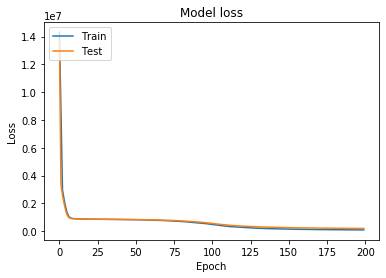

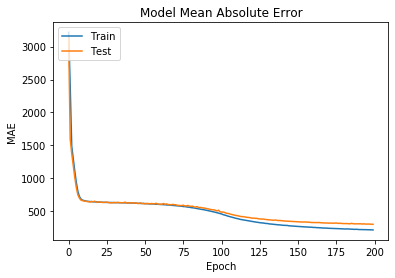

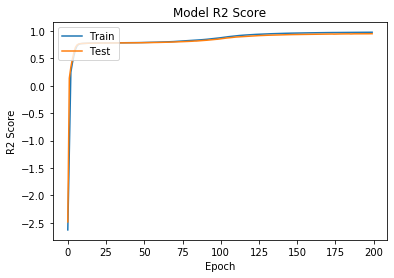

In [39]:
plt.plot(history_1.history['loss']) 
plt.plot(history_1.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

plt.plot(history_1.history['mae'])
plt.plot(history_1.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_1.history['keras_r2_score'])
plt.plot(history_1.history['val_keras_r2_score'])
plt.title('Model R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Valores obtidos na última época ao tentar prever o conjunto de teste:

In [37]:
print("MSE =", history_1.history['val_loss'][len(history_1.history['val_loss'])-1])
print("RMSE =", np.sqrt(history_1.history['val_loss'][len(history_1.history['val_loss'])-1]))
print("MAE =", history_1.history['val_mae'][len(history_1.history['val_mae'])-1])
print("R2 =", history_1.history['val_keras_r2_score'][len(history_1.history['val_keras_r2_score'])-1])

MSE = 195216.22993171832
RMSE = 441.83280766792126
MAE = 299.5264
R2 = 0.9501089


- **Segundo Split**

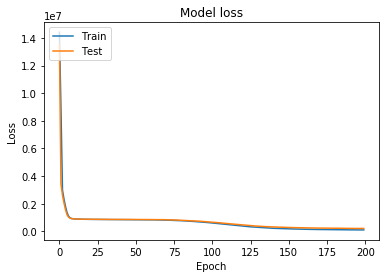

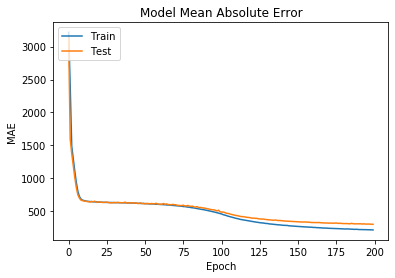

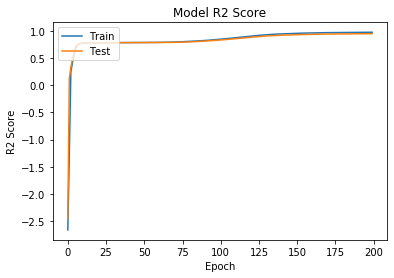

In [40]:
plt.plot(history_2.history['loss']) 
plt.plot(history_2.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

plt.plot(history_1.history['mae'])
plt.plot(history_1.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_2.history['keras_r2_score'])
plt.plot(history_2.history['val_keras_r2_score'])
plt.title('Model R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Valores obtidos na última época ao tentar prever o conjunto de teste:

In [38]:
print("MSE =", history_2.history['val_loss'][len(history_2.history['val_loss'])-1])
print("RMSE =", np.sqrt(history_2.history['val_loss'][len(history_2.history['val_loss'])-1]))
print("MAE =", history_2.history['val_mae'][len(history_2.history['val_mae'])-1])
print("R2 =", history_2.history['val_keras_r2_score'][len(history_2.history['val_keras_r2_score'])-1])

MSE = 202082.4487628001
RMSE = 449.5358147720826
MAE = 308.56366
R2 = 0.94885194


## Random Forest
- **Cross Validation**

In [34]:
print("MSE =", np.mean(rf_mse))
print("RMSE =", np.sqrt(np.mean(rf_mse)))
print("MAE =", np.mean(rf_mae))
print("R2 =", np.mean(rf_r2))

MSE = 984818.0960868122
RMSE = 992.3800159650598
MAE = 653.501041021779
R2 = 0.7496073237468674


- **Primeiro Split**

In [35]:
print("MSE =", mean_squared_error(y_test_s1, y_pred_s1))
print("RMSE =", np.sqrt(mean_squared_error(y_test_s1, y_pred_s1)))
print("MAE =", mean_absolute_error(y_test_s1, y_pred_s1))
print("R2 =", r2_score(y_test_s1, y_pred_s1))

MSE = 800283.0888157752
RMSE = 894.5854284615725
MAE = 573.3934989275583
R2 = 0.796910018560245


- **Segundo Split**

In [36]:
print("MSE =", mean_squared_error(y_test_s2, y_pred_s2))
print("RMSE =", np.sqrt(mean_squared_error(y_test_s2, y_pred_s2)))
print("MAE =", mean_absolute_error(y_test_s2, y_pred_s2))
print("R2 =", r2_score(y_test_s2, y_pred_s2))

MSE = 802275.1511740745
RMSE = 895.6981361899077
MAE = 571.5524797619871
R2 = 0.7961840310033662


Como se pode ver, em ambos regressores o método Houldout se saiu com melhores resultados em relação ao Cross Validation. Podemos também concluir que a regressão gerada pela Neural Network se sobressaiu em relação à Random Forest no quesito de ajustamento, conseguindo valores menores em suas métricas de distância, bem como um melhor R2 score.